# Level Set 水平集方法求解过程

## 1. 水平集方法概述
水平集方法是一种用于追踪界面和形状演化的数值技术，通过隐式表示界面为更高维函数的零等值面。

## 2. 基本数学表示
定义水平集函数 $\phi(\mathbf{x},t)$，其中：
- $\phi(\mathbf{x},0) = 0$ 表示初始界面
- $\phi(\mathbf{x},t) > 0$ 表示界面外部
- $\phi(\mathbf{x},t) < 0$ 表示界面内部

## 3. 求解过程

### 3.1 初始化
构建初始水平集函数 $\phi_0(\mathbf{x})$：
- 常用符号距离函数（SDF）初始化：
  $$
  \phi_0(\mathbf{x}) = \pm d(\mathbf{x},\Gamma)
  $$
  其中 $d$ 为点到界面 $\Gamma$ 的距离

### 3.2 演化方程
水平集函数遵循的PDE：
$$
\frac{\partial \phi}{\partial t} + F|\nabla \phi| = 0
$$
其中 $F$ 为速度函数，控制界面演化。

### 3.3 数值求解步骤

#### 步骤1：离散化
- 时间离散（前向欧拉法）：
  $$
  \phi^{n+1} = \phi^n - \Delta t \cdot F|\nabla \phi^n|
  $$

#### 步骤2：梯度计算
计算 $|\nabla \phi|$ 的离散方案：
1. 一阶迎风方案：
   $$
   |\nabla \phi| \approx \sqrt{\max(D_{-x}\phi,0)^2 + \min(D_{+x}\phi,0)^2 + \cdots}
   $$
2. ENO/WENO高阶格式

#### 步骤3：速度函数 $F$ 构建
$$
F = F_{\text{prop}} + F_{\text{curv}} + F_{\text{adv}}
$$
- $F_{\text{prop}}$：传播速度项
- $F_{\text{curv}} = -\epsilon\kappa$：曲率项（$\kappa$ 为平均曲率）
- $F_{\text{adv}}$：外力驱动项

#### 步骤4：重新初始化（Re-initialization）
求解稳态方程：
$$
\frac{\partial \phi}{\partial \tau} = \text{sign}(\phi_0)(1 - |\nabla \phi|)
$$
其中 $\tau$ 为伪时间

### 3.4 边界条件
- Neumann边界条件：$\frac{\partial \phi}{\partial \mathbf{n}} = 0$
- 周期性边界条件


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## 代码概述
该代码实现了基于水平集方法的界面演化模拟，主要包含时间积分、空间离散、曲率计算及演化过程。初始化为圆形界面，通过求解PDE模拟界面随时间的变化。

---

## 关键类与方法

### 1. `TimeScheme` 类
- **功能**：管理时间积分方案。
- **方法**：
  - `EulerForward`: 前向欧拉法更新解，公式为 `u_new = u_old + dt * rhs`。

### 2. `SpatialScheme` 类
- **功能**：定义空间离散格式。
- **方法**：
  - `Upwind`: 上风格式，计算相邻网格点的值差。

### 3. `levelset` 类
- **功能**：水平集方法的核心实现。
- **主要方法**：
  - `initialize`: 初始化符号距离函数（圆形界面）。
  - `boundary_condition`: 对称边界条件（镜像填充）。
  - `compute_curvature`: 计算曲率（用于界面演化）。
  - `rhs`: 计算右端项，结合上风格式处理对流项。
  - `evolve`: 执行时间迭代，周期性可视化结果。


In [2]:
class TimeScheme(object):
	def __init__(self, dt):
		self.dt = dt

	def EulerForward(self, u, rhs, i, j):
		return u[i, j] - self.dt * rhs(u, i, j)


In [3]:
class SpatialScheme:
	@staticmethod
	def Upwind(u, i, j, ii, jj):
		return u[i, j] - u[ii, jj]


In [4]:
class levelset:
	def __init__(self,phi, dt, nt, timesch, spatialsch):
		self.phi=phi
		self.nx=phi.shape[0]
		self.ny=phi.shape[1]
		self.nt = nt
		self.dx=1.0/(self.nx-1)
		self.dy=1.0/(self.ny-1)
		self.dt=dt
		self.initialize()
		self.timesch=timesch
		self.spatialsch=spatialsch
		self.narrowband = 8
		self.active = np.zeros((self.nx, self.ny))
		self.setActive()
		print(self.active.sum()/ (self.nx * self.ny))

	def initialize(self):
		for i in range(self.nx):
			for j in range(self.ny):
				# if np.sqrt((i-self.nx/2)*(i-self.nx/2)+(j-self.ny/2)*(j-self.ny/2)) < (self.nx/10):
				# 	self.phi[i,j]=-2
				# else:
				# 	self.phi[i,j]=2
				# self.phi[i,j]=np.sqrt((i-self.nx/2)*(i-self.nx/2)+(j-self.ny/2)*(j-self.ny/2))-(self.nx/10)
				self.phi[i, j] = max(self.nx/4 - i,  i - self.nx/1.5, self.ny/4 - j, j - self.ny/1.5)


	def setActive(self):
		self.active = np.zeros((self.nx, self.ny))
		self.active[np.abs(self.phi) <= self.narrowband] = 1
		# self.active = np.ones((self.nx, self.ny))

	def boundary_condition(self, phi):
		for i in range(self.nx):
			phi[i,0] = phi[i,1]
			phi[i,self.ny-1]=phi[i,self.ny-2]
		for j in range(self.ny):
			phi[0,j] = phi[1,j]
			phi[self.nx-1,j]=phi[self.nx-2,j]


	def reinitialize(self, step):
		phi0 = self.phi.copy()
		for _ in range(step):
			for i in range(1,self.nx-1):
				for j in range(1,self.ny-1):
					if self.active[i,j] == 0:
						continue
					grad_phi_x = (phi0[i+1,j]-phi0[i-1,j])/(2 * self.dx)
					grad_phi_y = (phi0[i,j+1]-phi0[i,j-1])/(2 * self.dy)
					grad_phi = np.sqrt(grad_phi_x**2+grad_phi_y**2)
					s = phi0[i,j] / np.sqrt(phi0[i,j]**2 + self.dx**2)
					dphi = s * (grad_phi - 1)
					phi0[i, j] = phi0[i, j] - self.dt * dphi
			self.boundary_condition(phi0)
		return phi0


	def compute_curvature(self, phi, i, j, dx, dy):
		# Calculate first derivatives using central differences
		phi_x = (phi[i+1, j] - phi[i-1, j]) / (2 * dx)
		phi_y = (phi[i, j+1] - phi[i, j-1]) / (2 * dy)
    
		# Calculate second derivatives
		phi_xx = (phi[i+1, j] - 2*phi[i, j] + phi[i-1, j]) / (dx**2)
		phi_yy = (phi[i, j+1] - 2*phi[i, j] + phi[i, j-1]) / (dy**2)
		phi_xy = (phi[i+1, j+1] - phi[i+1, j-1] - phi[i-1, j+1] + phi[i-1, j-1]) / (4 * dx * dy)	
		 
		epsilon = 1e-10
		grad_norm = np.sqrt(phi_x**2 + phi_y**2 + epsilon)
		kappa = (phi_xx * phi_y**2 - 2 * phi_x * phi_y * phi_xy + phi_yy * phi_x**2) / (grad_norm**3)
		if np.isnan(kappa):
			print(phi_x, phi_y, phi_xx, phi_yy, phi_xy, grad_norm, kappa)
		return kappa

	def F(self, i, j):
		kappa = self.compute_curvature(self.phi, i, j, self.dx, self.dy)
		# return 1.0 - np.cos(i/j)
		return 1.0 - kappa 

	def rhs(self, phi, i, j):
		delt_xn = self.spatialsch(phi, i, j, i-1, j)
		delt_yn = self.spatialsch(phi, i, j, i, j-1)
		delt_xp = self.spatialsch(phi, i+1, j, i, j)
		delt_yp = self.spatialsch(phi, i, j+1, i, j)
		deltp = max(delt_xn/self.dx, 0)**2 + max(delt_yn/self.dy, 0)**2 + min(delt_xp/self.dx, 0)**2 + min(delt_yp/self.dy, 0)**2
		deltn = max(delt_xp/self.dx, 0)**2 + max(delt_yp/self.dy, 0)**2 + min(delt_xn/self.dx, 0)**2 + min(delt_yn/self.dy, 0)**2
		F = self.F(i,j)
		return max(F, 0) * np.sqrt(deltp) + min(F, 0) * np.sqrt(deltn)

	def evolve(self):
		for t in range(self.nt):
			if t % 200 == 0:
				plt.figure(figsize=(4,4))
				plt.contour(np.linspace(0,1, self.nx), np.linspace(0,1,self.ny), self.phi, levels=[0], colors='r')
				plt.contour(np.linspace(0,1, self.nx), np.linspace(0,1,self.ny), self.phi, levels=[8], colors='b')
				plt.contour(np.linspace(0,1, self.nx), np.linspace(0,1,self.ny), self.phi, levels=[-8], colors='b')
				plt.title(f"time={t*self.dt}")
				plt.xlabel("x")
				plt.ylabel("y")
				plt.show()
			self.boundary_condition(self.phi)
			for i in range(1,self.nx-1):
				for j in range(1,self.ny-1):
					if self.active[i,j] == 0:
						continue
					self.phi[i, j] = self.timesch(self.phi, self.rhs, i, j)

			if t % 5 == 0:
				self.setActive()
				self.phi = self.reinitialize(10)

	

0.5247781065088757


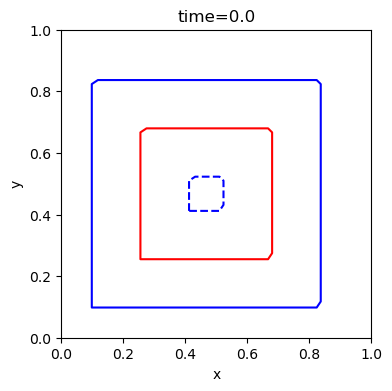

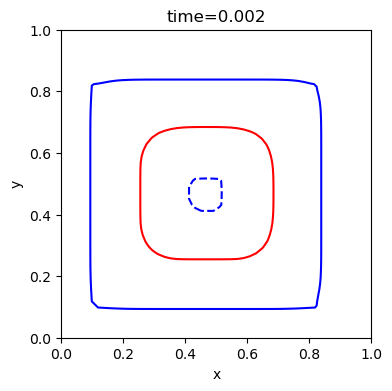

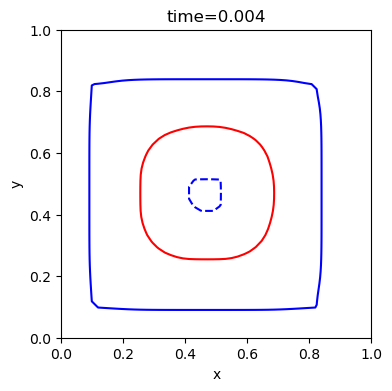

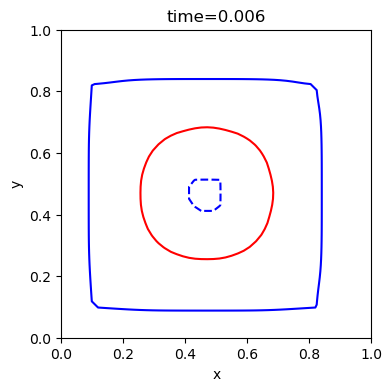

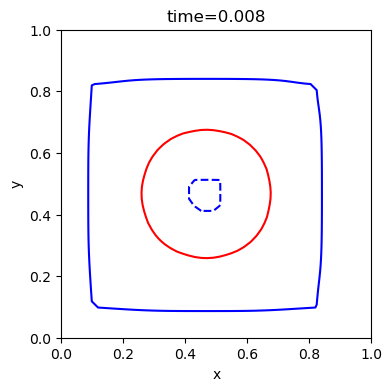

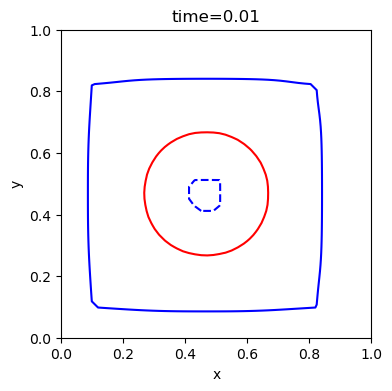

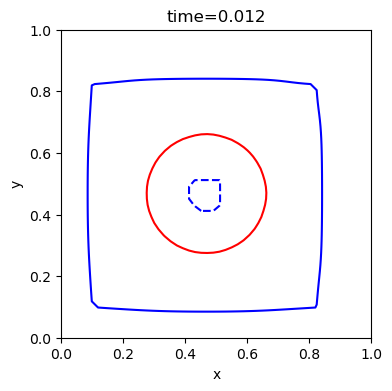

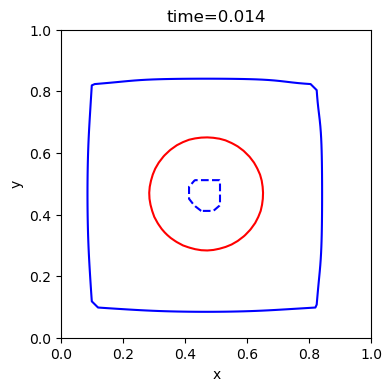

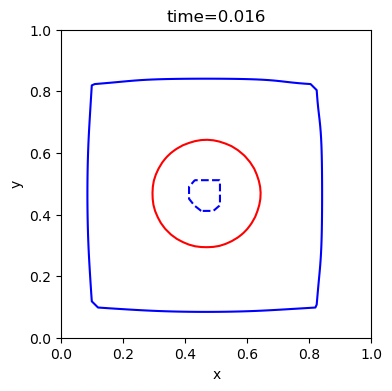

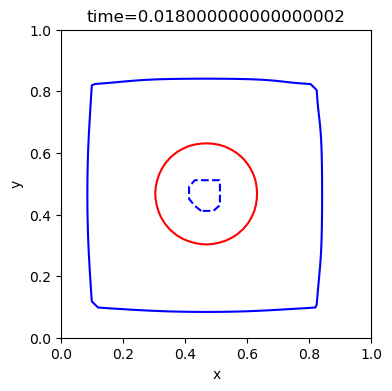

In [5]:
phi = np.zeros((50+2, 50+2))
dt = 0.00001
nt = 2000
timesch = TimeScheme(dt)
spatialsch = SpatialScheme
solver = levelset(phi, dt, nt, timesch.EulerForward, spatialsch.Upwind)
solver.evolve()